In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import torch.nn as nn

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
def load_dataset():
    train_dataset = h5py.File('Dataset_Path/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('Dataset_Path/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [11]:
#load the datasets
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [12]:
#flatten the images of datasets
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten =  test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

In [13]:
#normalize the datasets
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.

In [14]:
#sigmoid is used as activation function
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    return A

In [15]:
#initialize the parameter w and b with zeros
#these parameter will update with every iterations
def initialize_with_zeros(dim):
  w = np.zeros((dim,1))
  b = 0.0
  return w, b  

In [16]:
#forward and backward propagation
def propagate(w, b, X, Y):
  m = X.shape[1]
  Z = (np.dot(w.T,X)+b)
  A = sigmoid(Z)
  cost = np.sum((-Y*np.log(A))+(-(1-Y)*np.log(1-A)))/m
  dZ = A-Y
  dw = (np.dot(X,dZ.T))/m
  db = (np.sum(dZ))/m
  cost = np.squeeze(np.array(cost))
  grads = {"dw": dw,"db": db}
  return grads, cost

In [17]:
#optimize the model
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
  w = copy.deepcopy(w)
  b = copy.deepcopy(b)
  costs = []
  for i in range(num_iterations):
    grads, cost = propagate(w, b, X, Y)
    dw = grads["dw"]
    db = grads["db"]
    w = w - learning_rate*dw
    b = b - learning_rate*db
    if i % 500 == 0:
      costs.append(cost)
      if print_cost:
        print ("Cost after iteration %i: %f" %(i, cost))
  params = {"w": w,"b": b}   
  grads = {"dw": dw,"db": db}     
  return params, grads, costs


In [18]:
#predict the model's output as how much it accurately predict 
def predict(w, b, X):
  m = X.shape[1]
  Y_prediction = np.zeros((1, m))
  w = w.reshape(X.shape[0], 1)
  A = sigmoid(np.dot(w.T,X)+b)
  Y_prediction = (A>=0.5)*1.0
  return Y_prediction


In [19]:
#total model
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
  w,b = initialize_with_zeros(X_train.shape[0])
  params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
  w = params["w"]
  b = params["b"]
  Y_prediction_test = predict(w,b,X_test)
  Y_prediction_train = predict(w,b,X_train)
  if print_cost:
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
  d = {"costs": costs,"Y_prediction_test": Y_prediction_test, "Y_prediction_train" : Y_prediction_train, "w" : w, "b" : b,"learning_rate" : learning_rate,"num_iterations": num_iterations}
  return d  

In [20]:
# train and test the model
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=5000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 500: 0.303273
Cost after iteration 1000: 0.214820
Cost after iteration 1500: 0.166521
Cost after iteration 2000: 0.135608
Cost after iteration 2500: 0.114093
Cost after iteration 3000: 0.098280
Cost after iteration 3500: 0.086190
Cost after iteration 4000: 0.076662
Cost after iteration 4500: 0.068968
train accuracy: 100.0 %
test accuracy: 70.0 %


y = 0, you predicted that it is a "cat" picture.


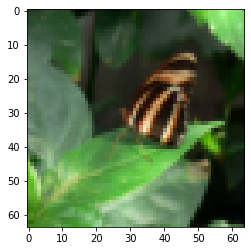

In [21]:
# Example of a picture that was wrongly classified.
num_px = 64
index = 5
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

In [22]:
# reshape the output for generating the confusion matrix
predicted = (logistic_regression_model["Y_prediction_test"]).reshape(50)
actual = test_set_y.reshape(50)

Confusion Matrix


Text(69.0, 0.5, 'Truth')

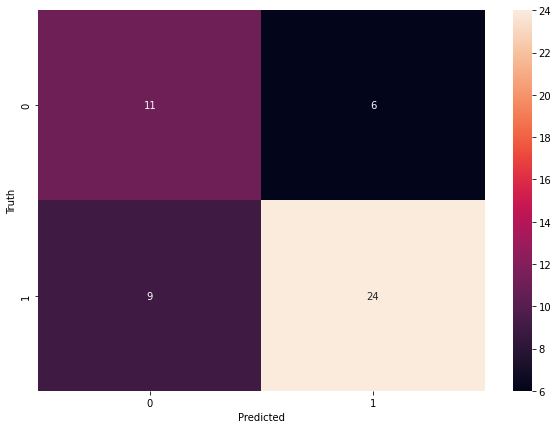

In [23]:
#confusion matrix
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
cm = tf.math.confusion_matrix(labels=actual,predictions=predicted)
import seaborn as sn
plt.figure(figsize = (10,7))
print("Confusion Matrix")
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

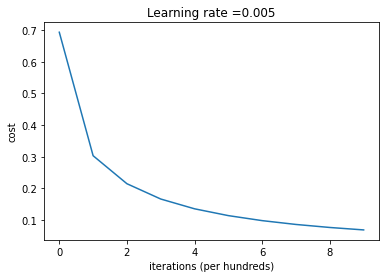

In [24]:
# Improvement
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()